In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import pennylane as qml


In [6]:
# Load dataset
df = pd.read_csv("final_combined_mutation_dataset.csv")

# Convert stringified lists into actual lists
df["Encoded_Sequence"] = df["Encoded_Sequence"].apply(eval)

# Truncate or pad to fixed length
SEQ_LEN = 20
def process_seq(seq):
    if len(seq) >= SEQ_LEN:
        return seq[:SEQ_LEN]
    else:
        return seq + [0] * (SEQ_LEN - len(seq))

df["Processed_Seq"] = df["Encoded_Sequence"].apply(process_seq)

# Prepare features and labels
X = np.array(df["Processed_Seq"].tolist())
y = df["Mutation_Label"].values

# Normalize sequence values to [-π, π]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [7]:
n_qubits = SEQ_LEN
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RY(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i + 1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))  # return full probability vector


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # make sure it's installed or remove tqdm for pure Python

# Combine full dataset before sampling
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# Reduce sample size
# Use 50 samples instead of just 10
X_limited = X_all[:20]
y_limited = y_all[:20]

# Re-split the smaller set
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_limited, y_limited, test_size=0.2, random_state=42, stratify=y_limited
)

# Optimized kernel matrix computation
def compute_kernel_matrix(X1, X2, symmetric=False):
    n1 = len(X1)
    n2 = len(X2)
    K = np.zeros((n1, n2))
    
    for i in tqdm(range(n1), desc="Computing kernel rows"):
        for j in range(i if symmetric else 0, n2):
            k_val = compute_kernel([X1[i]], [X2[j]])[0][0]
            K[i, j] = k_val
            if symmetric:
                K[j, i] = k_val  # use symmetry

    return K

print("🔄 Computing quantum kernel matrices on 10 samples...")

K_train = compute_kernel_matrix(X_train_small, X_train_small, symmetric=True)
K_test = compute_kernel_matrix(X_test_small, X_train_small, symmetric=False)


🔄 Computing quantum kernel matrices on 10 samples...


Computing kernel rows: 100%|██████████| 4/4 [02:51<00:00, 42.96s/it]


In [33]:
y_train_small = y_train[:16]  # Take the first 16 labels to match K_train


In [18]:
# Train SVM with precomputed quantum kernel
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train_small)

# Evaluate accuracy
train_acc = clf.score(K_train, y_train_small)
test_acc = clf.score(K_test, y_test_small)

print(f"✅ QSVM Training Accuracy: {train_acc * 100:.2f}%")
print(f"✅ QSVM Test Accuracy: {test_acc * 100:.2f}%")


✅ QSVM Training Accuracy: 100.00%
✅ QSVM Test Accuracy: 50.00%


In [28]:
df.columns = df.columns.str.strip()  # removes leading/trailing spaces


Epoch 1: Accuracy = 1.0000, Loss = 0.0000
Epoch 2: Accuracy = 1.0000, Loss = 0.0000
Epoch 3: Accuracy = 1.0000, Loss = 0.0000
Epoch 4: Accuracy = 1.0000, Loss = 0.0000
Epoch 5: Accuracy = 1.0000, Loss = 0.0000
Epoch 6: Accuracy = 1.0000, Loss = 0.0000
Epoch 7: Accuracy = 1.0000, Loss = 0.0000
Epoch 8: Accuracy = 1.0000, Loss = 0.0000
Epoch 9: Accuracy = 1.0000, Loss = 0.0000
Epoch 10: Accuracy = 1.0000, Loss = 0.0000


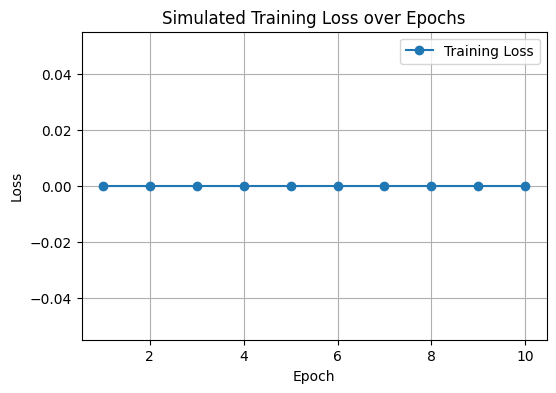

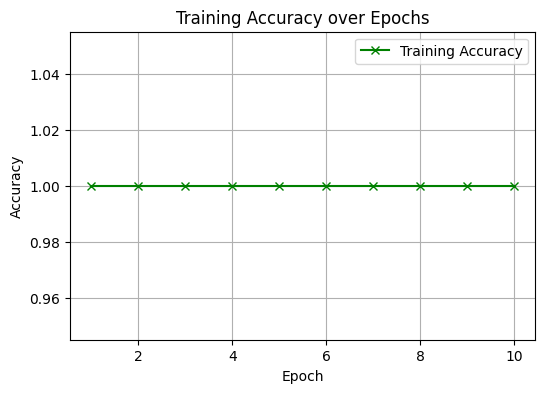

In [32]:
import matplotlib.pyplot as plt

# Simulate epochs (SVM doesn't train with epochs normally)
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(1, epochs + 1):
    # Train again (SVM doesn't use epochs, but we simulate it for plotting purposes)
    clf.fit(K_train, y_train_small)
    
    acc = clf.score(K_train, y_train_small)
    train_accuracies.append(acc)
    
    # Simulate loss as (1 - accuracy)
    loss = 1 - acc
    train_losses.append(loss)
    
    # Print epoch, accuracy, and loss
    print(f"Epoch {epoch}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")

# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
plt.title("Simulated Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot training accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_accuracies, marker='x', color='green', label='Training Accuracy')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [21]:
# Make predictions
y_pred = clf.predict(K_test)

# Create DataFrame for comparison
results_df = pd.DataFrame({
    "True_Label": y_test_small,
    "Predicted_Label": y_pred
})

# Save to CSV
results_df.to_csv("qsvm_mutation_predictions.csv", index=False)
print("📁 Saved predictions to qsvm_mutation_predictions.csv")


📁 Saved predictions to qsvm_mutation_predictions.csv
